# ImageDataGenerator
- 데이터를 불러오는 동시에 여러가지 전처리를 쉽게 구현할 수 있는 `tf.keras`의 기능
- `tf.data` 보다 쉽게 사용가능

In [24]:
import os
from glob import glob

import tensorflow as tf
import numpy as np
from PIL import Image
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## 1. ImageDataGenerator


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
datagen = ImageDataGenerator(rotation_range=20, 
                           width_shift_range=0.2, 
                           height_shift_range=0.2,
                          horizontal_flip=True)

```
rotation_range=20 : 회전하는 각도를 20도 내에서 무작위로 설정
width_shift_range=0.2 : 양옆으로 20% 이동 (random작용-이동할수도, 안할수도 있음)
height_shift_range=0.2 : 아래위로 20% 이동 (random작용-이동할수도, 안할수도 있음)
horizontal_flip=True
```
　　　$\to$ 사진을 무작위로 이동하며 ML 모델의 과적합을 방지 <br>
　　　$\to$ 따로 코드를 작성할 필요 없이, `ImageDataGenerator` 내에서 설정 가능!

## 2. flow
- 데이터를 모두 메모리에 불러두고 사용할 때

In [7]:
class Cifar10DataLoader():
    def __init__(self):
        # data load
        (self.train_x, self.train_y), \
            (self.test_x, self.test_y) = tf.keras.datasets.cifar10.load_data()
        self.input_shape = self.train_x.shape[1:]

    def scale(self, x):

        return (x / 255.0).astype(np.float32)

    def preprocess_dataset(self, dataset):

        (feature, target) = dataset

        # scaling #
        scaled_x = np.array([self.scale(x) for x in feature])

        # label encoding #
        ohe_y = np.array([tf.keras.utils.to_categorical(
            y, num_classes=10) for y in target])
        
        return scaled_x, ohe_y.squeeze(1)

    def get_train_dataset(self):
        return self.preprocess_dataset((self.train_x, self.train_y))

    def get_test_dataset(self):
        return self.preprocess_dataset((self.test_x, self.test_y))

cifar10_loader = Cifar10DataLoader()
train_x, train_y = cifar10_loader.get_train_dataset()

print(train_x.shape, train_x.dtype)
print(train_y.shape, train_y.dtype)

(50000, 32, 32, 3) float32
(50000, 10) float32


In [10]:
result = next(iter(datagen.flow(train_x, train_y)))
x, y = result

In [11]:
print(x.shape, y.shape)

(32, 32, 32, 3) (32, 10)


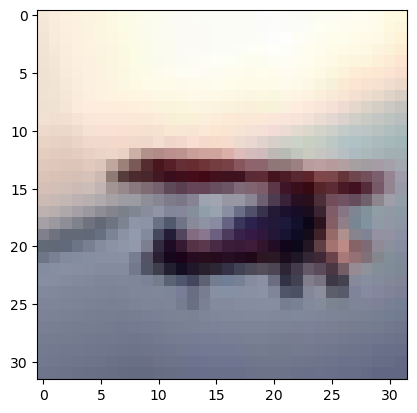

In [12]:
plt.imshow(x[0])
plt.show()

## 3. flow_from_directory
- 데이터가 메모리에 저장할 수 없을만큼 클 때


In [13]:
row_path = "E:/공부\제로베이스/Part 10. 텐서플로 & Part 11. 파이토치/deeplearning_frameworks_zerobaseDSS/"
train_dir = row_path + "datasets/mnist_png/training"

In [16]:
input_shape = (28, 28, 1)
batch_size = 32

In [19]:
gen = datagen.flow_from_directory(train_dir,
                           target_size=input_shape[:2], 
                            batch_size=batch_size,
                           color_mode="grayscale")

Found 60000 images belonging to 10 classes.


#####  color_mode: One of "grayscale", "rgb", "rgb". Default: "rgb".
    - 흑백(1채널) = "grayscale"
    - 컬러(3채널) = "rgb"
    - 4채널 = "rgb

In [22]:
x, y = next(iter(gen))
print(x.shape, y.shape)

(32, 28, 28, 1) (32, 10)


## 4. flow_from_DaraFrame

In [27]:
pd.read_csv(row_path+"datasets/cifar/train_dataset.csv")

,path,class_name
0,../../datasets/cifar/train/32270_deer.png,deer
1,../../datasets/cifar/train/21851_cat.png,cat
2,../../datasets/cifar/train/48309_deer.png,deer
3,../../datasets/cifar/train/33547_truck.png,truck
4,../../datasets/cifar/train/45202_automobile.png,automobile
...,...,...
49995,../../datasets/cifar/train/24599_horse.png,horse
49996,../../datasets/cifar/train/38514_automobile.png,automobile
49997,../../datasets/cifar/train/20054_deer.png,deer
49998,../../datasets/cifar/train/25602_bird.png,bird


In [33]:
train_data = pd.read_csv(row_path+"datasets/cifar/train_dataset.csv")

datagen.flow_from_dataframe(train_data,
                            x_col="path",
                            y_col="class_name",
                            target_size=(32, 32),
                            color_mode="rgb", 
                            class_model="categorical",
                            batch_size=32)

Found 0 validated image filenames belonging to 0 classes.


C:\Users\gktna\miniconda3\envs\soo\lib\site-packages\keras\preprocessing\image.py:1137: UserWarning: Found 50000 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


In [34]:
x, y = next(iter(datagen.flow((train_x, train_y))))

print(x.shape)
print(y.shape)

(32, 32, 32, 3)
(32, 10)


## 학습시키기

In [35]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Add

def build_resnet(input_shape):
    inputs = Input(input_shape)

    net = Conv2D(32, kernel_size=3, strides=2,
                 padding='same', activation='relu')(inputs)
    net = MaxPool2D()(net)
    
    net1 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net)
    net2 = Conv2D(64, kernel_size=3, padding='same', activation='relu')(net1)
    net3 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net2)
    
    net1_1 = Conv2D(64, kernel_size=1, padding='same')(net)
    net = Add()([net1_1, net3])
    
    net1 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net)
    net2 = Conv2D(64, kernel_size=3, padding='same', activation='relu')(net1)
    net3 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net2)
    
    net = Add()([net, net3])
    
    net = MaxPool2D()(net)
    
    net = Flatten()(net)
    net = Dense(10, activation="softmax")(net)

    model = tf.keras.Model(inputs=inputs, outputs=net, name='resnet')
    
    return model

model = build_resnet((32, 32, 3))
model.summary()

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   896         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 8, 8, 32)     0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 64)     2112        ['max_pooling2d[0][0]']          
                                                                                             

In [36]:
learning_rate = 0.03
opt = tf.keras.optimizers.Adam(learning_rate)
loss = tf.keras.losses.categorical_crossentropy

model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

In [37]:
model.fit(datagen.flow((train_x, train_y)))

1563/1563 [==============================] - 92s 58ms/step - loss: 2.3707 - accuracy: 0.0985


In [ ]:
# model.fit(gen) 도 가능